In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
# g = builder([
#     nn.Linear(100+10, 128),
#     nn.BatchNorm1d(128),
#     nn.ReLU(),
#     nn.Linear(128, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.Linear(256, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.Linear(512, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.Linear(512, 784),
#     layer.Reshape((-1, 1, 28, 28)),
#     nn.Sigmoid(),
    
# ])

In [4]:
class ToLong(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.long()

In [5]:
class ConditionProjection(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    
    def forward(self, x):
        data, condition = x
        return torch.cat([data, self.f(condition)], dim=1)

In [6]:
p = builder([
    nn.Linear(10, 512),
    nn.ReLU(),
    nn.Linear(512, 784),
    layer.Reshape((-1, 1, 28, 28))
])

In [7]:
# d = builder([
#     #ConditionProjection(p),
#     nn.Conv2d(1, 32, 5),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 32, 3, 1, 1),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 32, 3, 1, 1),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.MaxPool2d(2),
#     layer.Flatten(),
#     Auxiliary(builder([
#         nn.Linear(288, 10),
#         nn.LogSoftmax(-1)
#     ])),
#     nn.Linear(288, 1),
#     nn.Sigmoid(),
# ])

In [8]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x
    
g = generator()

In [9]:
class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=28, class_num=10):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        #d = self.dc(x)
        #c = self.cl(x)
        return x

d = builder([
    discriminator(),
    Auxiliary(builder([
        nn.Linear(1024, 10),
        nn.LogSoftmax()
    ])),
    nn.Linear(1024, 1),
    nn.Sigmoid(),
])

In [10]:
train_loader = VisionDataset(vision.MNIST, batch_size=32, train=True, normalize=False)

In [11]:
runner = Runner(GANModel(g, d, condition=[True, False]), train_loader, None, 'rmsprop', GANLoss('vanilla', aux_loss=F.nll_loss))

In [12]:
runner.init_model('orthogonal')

Init orthogonal: Linear(in_features=110, out_features=1024, bias=True)
Init orthogonal: Linear(in_features=1024, out_features=8192, bias=True)
Init orthogonal: Sequential(
  (0): Linear(in_features=110, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=8192, bias=True)
  (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)
Init orthogonal: Sequential(
  (0): Linear(in_features=110, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=8192, bias=True)
  (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)
Init orthogonal: ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
Init orthogonal: ConvTranspose2d(64, 1, kern

Init orthogonal: Sequential(
  (0): discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (fc1): Sequential(
      (0): Linear(in_features=6272, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Auxiliary(
    (f): Sequential(
      (0): Linear(in_features=1024, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
  (2): Linear(in_features=1024, out_features=1, bias=True)
  (3): Sigmoid()
)
Init orthogonal: Sequential(
  (0): discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=

In [13]:
runner.fit(10)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  Epochs   train_d_loss  train_g_loss 
    1         1.4049        1.3078    


    2         1.2551        1.0276    


    3         1.2235        1.0837    


    4         1.1727        1.0801    


    5         1.1314        1.1683    


    6         1.0847        1.1887    


    7         1.0487        1.2918    


    8         1.0082        1.3138    


    9         0.9721        1.4237    


    10        0.9319        1.4467    



In [14]:
condition = to_one_hot(torch.from_numpy(np.array(list(range(10)))).cuda(), 10).cuda()
img = runner.model.sample(10, condition_data=condition)

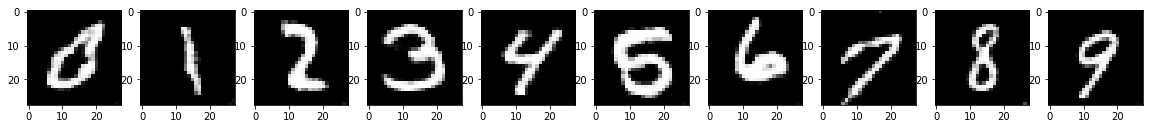

In [15]:
import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    arr[i].imshow(img[i][0].detach().cpu().numpy(), cmap='gray')
plt.show()

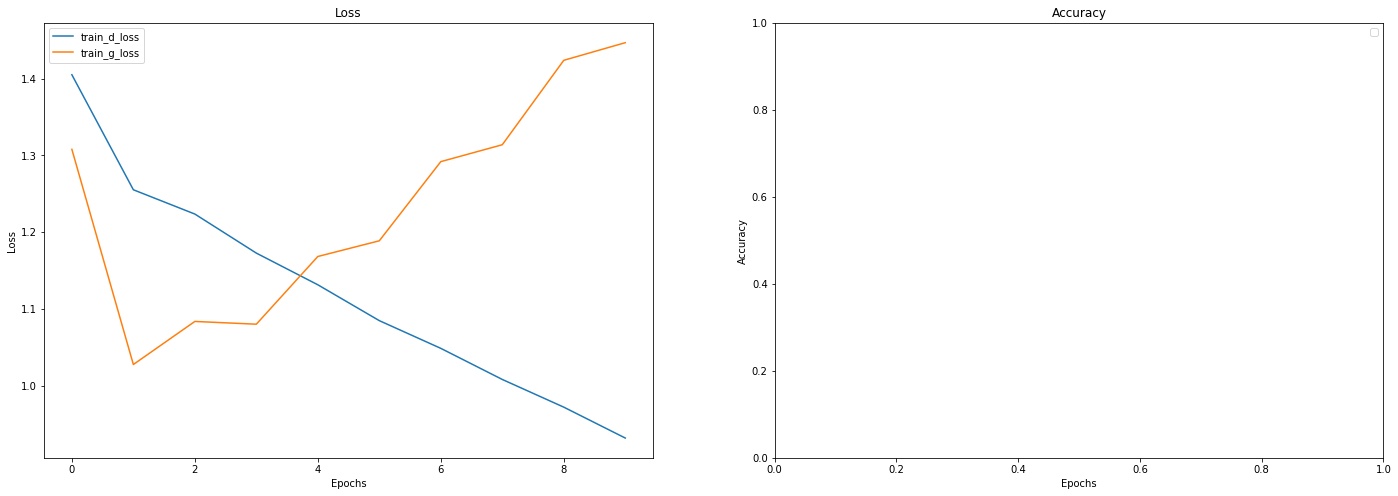

In [16]:
runner.history()

In [26]:
import torch
from torchvision import models

def get_seq_exec_list(model):
    DUMMY_INPUT = torch.randn(1, 110).cuda()
    model.eval()
    traced= torch.jit.trace(model, (DUMMY_INPUT,), check_trace=False)
    seq_exec_list = traced.code
    seq_exec_list = seq_exec_list.split('\n')
    for idx, item in enumerate(seq_exec_list):
        print('[{}]: {}'.format(idx, item))
    return traced.code
        
t = get_seq_exec_list(g)

[0]: def forward(self,
[1]:     input: Tensor) -> Tensor:
[2]:   input0 = torch.addmm(getattr(self.fc, "0").bias, input, torch.t(getattr(self.fc, "0").weight), beta=1, alpha=1)
[3]:   input1 = torch.batch_norm(input0, getattr(self.fc, "1").weight, getattr(self.fc, "1").bias, getattr(self.fc, "1").running_mean, getattr(self.fc, "1").running_var, False, 0., 1.0000000000000001e-05, True)
[4]:   input2 = torch.threshold(input1, 0., 0.)
[5]:   input3 = torch.addmm(getattr(self.fc, "3").bias, input2, torch.t(getattr(self.fc, "3").weight), beta=1, alpha=1)
[6]:   input4 = torch.batch_norm(input3, getattr(self.fc, "4").weight, getattr(self.fc, "4").bias, getattr(self.fc, "4").running_mean, getattr(self.fc, "4").running_var, False, 0., 1.0000000000000001e-05, True)
[7]:   x = torch.threshold(input4, 0., 0.)
[8]:   input5 = torch.view(x, [-1, 128, 8, 8])
[9]:   input6 = torch._convolution(input5, getattr(self.deconv, "0").weight, getattr(self.deconv, "0").bias, [2, 2], [1, 1], [1, 1], True, [0, 

In [37]:
from torch import Tensor
exec(t)

In [41]:
g

generator(
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=8192, bias=True)
    (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)